In [16]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [17]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [19]:
# load data
df = pd.read_csv('/content/spam.csv', encoding='latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [20]:
# We only need first two columns, drop the rest
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'])
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [21]:
# Rename first two columns
df.columns=['target', 'message']
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# EDA

In [6]:
df.shape

(5572, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   target   5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
df.describe()

,target,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [9]:
df.nunique()

target        2
message    5169
dtype: int64

In [10]:
# Let's check to make sure no null values
df.isnull().sum()

target     0
message    0
dtype: int64

In [11]:
# We want to know the message length,
# Let's add another column to our dataframe that displays this
df['len'] = df['message'].apply(len)
df.head()

,target,message,len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Data Visualization

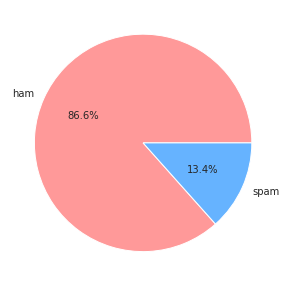

In [12]:
# Pie chart of ham vs. spam text
import seaborn as sns

sns.set_style(style='darkgrid')
plt.figure(figsize=(10,5))
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct='%1.1f%%', 
        colors = ['#ff9999','#66b3ff'])
plt.show()

In [13]:
# Let's find the exact number of spam vs ham
df.groupby('target')['target'].agg('count').values

array([4825,  747])

In [14]:
# 747 spam texts, 4825 ham texts

In [14]:
# Find max length
print(df['len'].max())

910


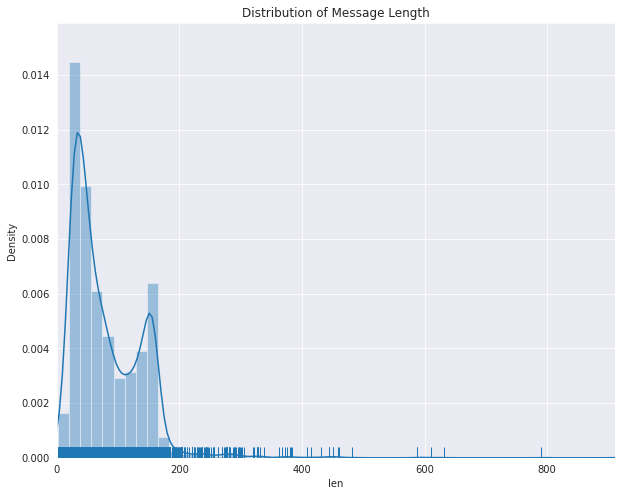

In [15]:
# Plot distribution of message length
plt.figure(figsize=(10,8))
sns.color_palette('pastel')
sns.distplot(df.len,kde=True,rug=True)
plt.title("Distribution of Message Length")
plt.xlim([0,910])
plt.show()

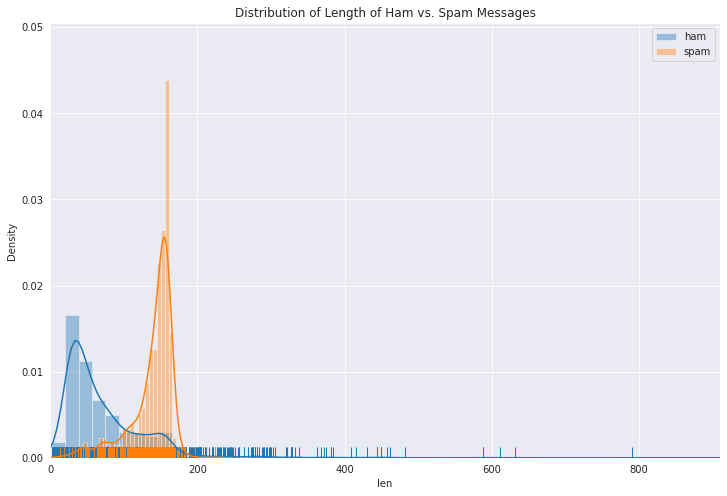

In [16]:
# Plot spam vs. ham
plt.figure(figsize=(12,8))
sns.color_palette('pastel')
sns.distplot(df[df['target']=='ham'].len, kde=True, rug=True, label='ham')
sns.distplot(df[df['target']=='spam'].len, kde=True, rug=True, label='spam')
plt.title("Distribution of Length of Ham vs. Spam Messages")
plt.xlim([0,910])
plt.legend()
plt.show()

In [18]:
# We see spam text tend to be longer

# Data PreProcessing

In [22]:
# Import libraries
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.models import Sequential
from keras.utils import to_categorical

from bs4 import BeautifulSoup
import nltk
import nltk
nltk.download('stopwords')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
# Replace ham: 0, spam: 1
df.target.replace({'spam':1,'ham':0},inplace = True)

In [47]:
# Make a function to clean text
def clean_text(text):
  # Strip HTML tags from text
  soup = BeautifulSoup(text, 'html.parser')
  text = soup.get_text()
  
  # Remove URLs
  text = re.sub('http\S+', '', text)
  
  # Remove brackets
  text = re.sub('\[[^\]]*\]', '', text)

  # Remove punctuation
  text = re.sub(r'[^\w\s]','', text)

  # Remove stopwords
  text = ' '.join(word for word in text.split(' ') if word not in stopwords.words('english'))

  # Return cleaned text
  return text

Note: removing punctuation from texts decreased accuracy of model

In [48]:
# Apply function to dataset
from nltk.corpus import stopwords
df['clean_message'] = df['message'].apply(clean_text)
df.head()

,target,message,clean_message
0,0,"Go until jurong point, crazy.. Available only ...",Go jurong point crazy Available bugis n great ...
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry 2 wkly comp win FA Cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,U dun say early hor U c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think goes usf lives around though


In [23]:
# Messages are now cleaned!

In [49]:
# Let's look at the top 25 common ham words
import string
from collections import Counter

words = df[df.target==0].clean_message.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for text in words:
    ham_words.update(text)

for word, count in ham_words.most_common(25):
    print(word, ": ", count)

i :  1448
u :  972
im :  449
2 :  305
get :  303
ok :  272
dont :  257
go :  247
ur :  240
ill :  236
know :  232
got :  231
like :  229
call :  229
come :  224
good :  222
you :  213
time :  196
day :  187
love :  185
4 :  168
going :  167
want :  163
one :  162
home :  160


In [50]:
# Let's look at the top 25 common spam words
import string
from collections import Counter

words = df[df.target==1].clean_message.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for text in words:
    spam_words.update(text)

for word, count in spam_words.most_common(25):
    print(word, ": ", count)

call :  347
free :  217
2 :  173
txt :  150
u :  147
ur :  144
mobile :  123
text :  120
4 :  119
claim :  113
stop :  113
you :  102
reply :  101
prize :  92
get :  83
to :  78
your :  76
new :  69
send :  67
nokia :  65
urgent :  63
cash :  62
win :  60
now :  58
contact :  56


In [51]:
# Populate X w/ 4th column
X = df['clean_message']
# Populate y w/ 1st column
y = df['target']

In [52]:
X.shape

(5572,)

In [53]:
y.shape

(5572,)

In [54]:
max(map(len, X))

530

In [75]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.message, df.target,
                                                    test_size=0.3,
                                                    random_state=123)

In [56]:
# Let's look at the size of our train vs. test sets
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

3900 3900
1672 1672


In [76]:
VOCAB_SIZE=5573 # 5572+1
MAXLEN=250
embedding_dim=16

In [77]:
# Tokenize messages
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

# Transform to sequence of integers
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [59]:
# Pad sequences
X_train = pad_sequences(X_train, maxlen=MAXLEN)
X_test = pad_sequences(X_test, maxlen=MAXLEN)

Modeling the Data

In [60]:
from keras.api._v2.keras import layers
import tensorflow as tf

# Create Sequential model
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=embedding_dim, 
                                  input_length=MAXLEN),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.2), # to avoid overfitting
        tf.keras.layers.Dense(1, activation="sigmoid")
        ])

In [61]:
# Look at a summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 16)           89168     
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 89,601
Trainable params: 89,601
Non-trainable params: 0
__________________________________________________

In [62]:
# Compile the model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [63]:
history = model.fit(X_train, y_train, 
                    epochs=30, 
                    validation_data=(X_test, y_test))

Epoch 1/30
122/122 [==============================] - 1s 7ms/step - loss: 0.5074 - accuracy: 0.8636 - val_loss: 0.3788 - val_accuracy: 0.8714
Epoch 2/30
122/122 [==============================] - 1s 6ms/step - loss: 0.3935 - accuracy: 0.8636 - val_loss: 0.3672 - val_accuracy: 0.8714
Epoch 3/30
122/122 [==============================] - 1s 6ms/step - loss: 0.3833 - accuracy: 0.8636 - val_loss: 0.3594 - val_accuracy: 0.8714
Epoch 4/30
122/122 [==============================] - 1s 5ms/step - loss: 0.3706 - accuracy: 0.8636 - val_loss: 0.3500 - val_accuracy: 0.8714
Epoch 5/30
122/122 [==============================] - 1s 6ms/step - loss: 0.3572 - accuracy: 0.8636 - val_loss: 0.3344 - val_accuracy: 0.8714
Epoch 6/30
122/122 [==============================] - 1s 6ms/step - loss: 0.3367 - accuracy: 0.8636 - val_loss: 0.3104 - val_accuracy: 0.8714
Epoch 7/30
122/122 [==============================] - 1s 5ms/step - loss: 0.3009 - accuracy: 0.8638 - val_loss: 0.2666 - val_accuracy: 0.8714
Epoch 

In [64]:
# Look at results
results = model.evaluate(X_test, y_test)
print("The accuracy is: ", results[1]*100, '%')

53/53 [==============================] - 0s 2ms/step - loss: 0.0435 - accuracy: 0.9874
The accuracy is:  98.74401688575745 %


In [43]:
# Model has an accuracy of over 98%

Use Model to Make Predictions

In [65]:
def predict_message(text):
  # Convert text to integer sequence
  new_text = tokenizer.texts_to_sequences(text)
  
  # Pad sequence
  new_text = pad_sequences(new_text, maxlen=MAXLEN)
  
  # Predict results
  result = model.predict(new_text)
  if result[0] > 0.5:
    print('Message: ', text[0])
    print('This message is spam!')
    print(result[0])
    print()
  else:
    print('Message: ', text[0])
    print('This message is real!')
    print(result[0])
    print()

In [66]:
# Check with some text messages
# Note: input message MUST be in from of array
# Ex: predict_message(['Input message here'])
predict_message(["ClTlBANK- A purchase of $946.68 on your debit is on hold. Reply YES to approve. If unrecognized, Visit CiticlientAuth01.com to cancel. Reply STOP to Opt-out."])

predict_message(["Going to the beach later, do you want to come?"])

predict_message(["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"])

predict_message(["our new mobile video service is live. just install on your phone to start watching."])

predict_message(["sale today! to stop texts call 98912460324"])

predict_message(["wow, is your arm alright? that happened to me one time too"])

predict_message(["I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."])

predict_message(["Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450p Provided by tones2you.co.uk	"])

1/1 [==============================] - 0s 58ms/step
Message:  ClTlBANK- A purchase of $946.68 on your debit is on hold. Reply YES to approve. If unrecognized, Visit CiticlientAuth01.com to cancel. Reply STOP to Opt-out.
This message is spam!
[0.998478]

1/1 [==============================] - 0s 18ms/step
Message:  Going to the beach later, do you want to come?
This message is real!
[0.00199668]

1/1 [==============================] - 0s 18ms/step
Message:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
This message is spam!
[0.99995476]

1/1 [==============================] - 0s 18ms/step
Message:  our new mobile video service is live. just install on your phone to start watching.
This message is spam!
[0.9934698]

1/1 [==============================] - 0s 23ms/step
Message:  sale today! to stop texts call 98912460324
This message is spam!
[0.6207549]

1/1 [=====================

The model successfully classified the texts!
Now, let's build an interactive app to deploy the model to. 

In [67]:
# First, save the model and download it locally
import pickle

filename = 'sms_model.pkl'
pickle.dump(model, open(filename, 'wb'))

from google.colab import files
files.download('sms_model.pkl') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
# Now save and download tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

from google.colab import files
files.download('tokenizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Building the Web App

We'll use Flask to deploy the app

In [68]:
# Install libraries
!pip install flask-ngrok
!pip install flask-bootstrap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Create .html file for web page

In [70]:
%mkdir templates -p

In [71]:
%%writefile templates/index.html

<!DOCTYPE html>
<html >
<!--From https://codepen.io/frytyler/pen/EGdtg-->
<head>
  <meta charset="UTF-8">
  <title>ML API</title>
  <link href='https://fonts.googleapis.com/css?family=Pacifico' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Arimo' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Hind:300' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Open+Sans+Condensed:300' rel='stylesheet' type='text/css'>
<link rel="stylesheet" href="{{ url_for('static', filename='css/style.css') }}">
  
</head>

<body>
 <div class="login">
	<h1>SMS Spam Filter</h1>

     <!-- Main Input For Receiving Query to our ML -->
    <form action="{{ url_for('predict')}}"method="post">
    	<input type="text" name="text" placeholder="Enter the suspicious sms here" required="required" />
       
        <button type="submit" class="btn btn-primary btn-block btn-large">Predict</button>
    </form>

   <br>
   <br>
   {{ prediction_text }}

 </div>


</body>
</html>

Overwriting templates/index.html


Style web page using css. Followed tutorial from: 
https://www.youtube.com/watch?v=UbCWoMf80PY&ab_channel=KrishNaik 

In [5]:
%mkdir static -p

In [72]:
%%writefile static/css/style.css

@import url(https://fonts.googleapis.com/css?family=Open+Sans);
.btn { display: inline-block; *display: inline; *zoom: 1; padding: 4px 10px 4px; margin-bottom: 0; font-size: 13px; line-height: 18px; color: #333333; text-align: center;text-shadow: 0 1px 1px rgba(255, 255, 255, 0.75); vertical-align: middle; background-color: #f5f5f5; background-image: -moz-linear-gradient(top, #ffffff, #e6e6e6); background-image: -ms-linear-gradient(top, #ffffff, #e6e6e6); background-image: -webkit-gradient(linear, 0 0, 0 100%, from(#ffffff), to(#e6e6e6)); background-image: -webkit-linear-gradient(top, #ffffff, #e6e6e6); background-image: -o-linear-gradient(top, #ffffff, #e6e6e6); background-image: linear-gradient(top, #ffffff, #e6e6e6); background-repeat: repeat-x; filter: progid:dximagetransform.microsoft.gradient(startColorstr=#ffffff, endColorstr=#e6e6e6, GradientType=0); border-color: #e6e6e6 #e6e6e6 #e6e6e6; border-color: rgba(0, 0, 0, 0.1) rgba(0, 0, 0, 0.1) rgba(0, 0, 0, 0.25); border: 1px solid #e6e6e6; -webkit-border-radius: 4px; -moz-border-radius: 4px; border-radius: 4px; -webkit-box-shadow: inset 0 1px 0 rgba(255, 255, 255, 0.2), 0 1px 2px rgba(0, 0, 0, 0.05); -moz-box-shadow: inset 0 1px 0 rgba(255, 255, 255, 0.2), 0 1px 2px rgba(0, 0, 0, 0.05); box-shadow: inset 0 1px 0 rgba(255, 255, 255, 0.2), 0 1px 2px rgba(0, 0, 0, 0.05); cursor: pointer; *margin-left: .3em; }
.btn:hover, .btn:active, .btn.active, .btn.disabled, .btn[disabled] { background-color: #e6e6e6; }
.btn-large { padding: 9px 14px; font-size: 15px; line-height: normal; -webkit-border-radius: 5px; -moz-border-radius: 5px; border-radius: 5px; }
.btn:hover { color: #333333; text-decoration: none; background-color: #e6e6e6; background-position: 0 -15px; -webkit-transition: background-position 0.1s linear; -moz-transition: background-position 0.1s linear; -ms-transition: background-position 0.1s linear; -o-transition: background-position 0.1s linear; transition: background-position 0.1s linear; }
.btn-primary, .btn-primary:hover { text-shadow: 0 -1px 0 rgba(0, 0, 0, 0.25); color: #ffffff; }
.btn-primary.active { color: rgba(255, 255, 255, 0.75); }
.btn-primary { background-color: #4a77d4; background-image: -moz-linear-gradient(top, #6eb6de, #4a77d4); background-image: -ms-linear-gradient(top, #6eb6de, #4a77d4); background-image: -webkit-gradient(linear, 0 0, 0 100%, from(#6eb6de), to(#4a77d4)); background-image: -webkit-linear-gradient(top, #6eb6de, #4a77d4); background-image: -o-linear-gradient(top, #6eb6de, #4a77d4); background-image: linear-gradient(top, #6eb6de, #4a77d4); background-repeat: repeat-x; filter: progid:dximagetransform.microsoft.gradient(startColorstr=#6eb6de, endColorstr=#4a77d4, GradientType=0);  border: 1px solid #3762bc; text-shadow: 1px 1px 1px rgba(0,0,0,0.4); box-shadow: inset 0 1px 0 rgba(255, 255, 255, 0.2), 0 1px 2px rgba(0, 0, 0, 0.5); }
.btn-primary:hover, .btn-primary:active, .btn-primary.active, .btn-primary.disabled, .btn-primary[disabled] { filter: none; background-color: #4a77d4; }
.btn-block { width: 100%; display:block; }

* { -webkit-box-sizing:border-box; -moz-box-sizing:border-box; -ms-box-sizing:border-box; -o-box-sizing:border-box; box-sizing:border-box; }

html { width: 100%; height:100%; overflow:hidden; }

body { 
	width: 100%;
	height:100%;
	font-family: 'Open Sans', sans-serif;
	background: #092756;
	color: #fff;
	font-size: 18px;
	text-align:center;
	letter-spacing:1.2px;
	background: -moz-radial-gradient(0% 100%, ellipse cover, rgba(104,128,138,.4) 10%,rgba(138,114,76,0) 40%),-moz-linear-gradient(top,  rgba(57,173,219,.25) 0%, rgba(42,60,87,.4) 100%), -moz-linear-gradient(-45deg,  #670d10 0%, #092756 100%);
	background: -webkit-radial-gradient(0% 100%, ellipse cover, rgba(104,128,138,.4) 10%,rgba(138,114,76,0) 40%), -webkit-linear-gradient(top,  rgba(57,173,219,.25) 0%,rgba(42,60,87,.4) 100%), -webkit-linear-gradient(-45deg,  #670d10 0%,#092756 100%);
	background: -o-radial-gradient(0% 100%, ellipse cover, rgba(104,128,138,.4) 10%,rgba(138,114,76,0) 40%), -o-linear-gradient(top,  rgba(57,173,219,.25) 0%,rgba(42,60,87,.4) 100%), -o-linear-gradient(-45deg,  #670d10 0%,#092756 100%);
	background: -ms-radial-gradient(0% 100%, ellipse cover, rgba(104,128,138,.4) 10%,rgba(138,114,76,0) 40%), -ms-linear-gradient(top,  rgba(57,173,219,.25) 0%,rgba(42,60,87,.4) 100%), -ms-linear-gradient(-45deg,  #670d10 0%,#092756 100%);
	background: -webkit-radial-gradient(0% 100%, ellipse cover, rgba(104,128,138,.4) 10%,rgba(138,114,76,0) 40%), linear-gradient(to bottom,  rgba(57,173,219,.25) 0%,rgba(42,60,87,.4) 100%), linear-gradient(135deg,  #670d10 0%,#092756 100%);
	filter: progid:DXImageTransform.Microsoft.gradient( startColorstr='#3E1D6D', endColorstr='#092756',GradientType=1 );

}
.login { 
	position: absolute;
	top: 40%;
	left: 50%;
	margin: -150px 0 0 -150px;
	width:400px;
	height:400px;
}

.login h1 { color: #fff; text-shadow: 0 0 10px rgba(0,0,0,0.3); letter-spacing:1px; text-align:center; }

input { 
	width: 100%; 
	margin-bottom: 10px; 
	background: rgba(0,0,0,0.3);
	border: none;
	outline: none;
	padding: 10px;
	font-size: 13px;
	color: #fff;
	text-shadow: 1px 1px 1px rgba(0,0,0,0.3);
	border: 1px solid rgba(0,0,0,0.3);
	border-radius: 4px;
	box-shadow: inset 0 -5px 45px rgba(100,100,100,0.2), 0 1px 1px rgba(255,255,255,0.2);
	-webkit-transition: box-shadow .5s ease;
	-moz-transition: box-shadow .5s ease;
	-o-transition: box-shadow .5s ease;
	-ms-transition: box-shadow .5s ease;
	transition: box-shadow .5s ease;
}
input:focus { box-shadow: inset 0 -5px 45px rgba(100,100,100,0.4), 0 1px 1px rgba(255,255,255,0.2); }

Overwriting static/css/style.css


In [73]:
import os
import threading
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf

In [8]:
# Import model file
from google.colab import files
uploaded = files.upload()

Saving sms_model.pkl to sms_model.pkl


In [ ]:
import pickle
import numpy as np

from flask import Flask, render_template, request
from flask_bootstrap import Bootstrap
from pyngrok import ngrok
from flask_ngrok import run_with_ngrok

import warnings
warnings.filterwarnings('ignore')

# Define tokenizer to process input 
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

app = Flask(__name__, static_folder='/content/static')
port = 5000
ngrok.set_auth_token('2HkK81Udq76zgUa5HNpmtOe8TIo_4jkv4PTwnhKewdFbBNkgt')
#public_url = ngrok.connect(port).public_url
bootstrap = Bootstrap(app)
run_with_ngrok(app)

# Load in model
def read_file():
    with open('/content/sms_model.pkl', 'rb') as inputfile:
        model = pickle.load(inputfile)
    return model

@app.route('/', methods=['GET'])
def home():
  return render_template('index.html')

@app.route('/', methods=['GET', "POST"])
def predict():
  # Get text from user
  text = request.form.values()
  # Convert text to integer sequence
  new_text = tokenizer.texts_to_sequences(text)
  # Pad sequence
  new_text = pad_sequences(new_text, maxlen=250) # MAXLEN=250
  # Predict results
  result = model.predict(new_text)
  if result[0] > 0.55:
    return render_template('index.html', prediction_text='This message is spam! Be careful!')
  elif result[0] > 0.48 and result[0] < 0.55: # Range of caution
    return render_template('index.html', prediction_text='This message is probably spam. Take caution.')
  else:
    return render_template('index.html', prediction_text='This message is real! Happy texting!')

if __name__ == '__main__':
    model = read_file()
    app.run()